#### 📝 Problemática de Estadística Multivariada: Análisis del Rendimiento Académico en Universidades


**Profesora: Rocío Leonel Gómez**

**Alumna: González Pineda Alejandra Quetzal**

---

#### Contexto

El rendimiento académico de los estudiantes en universidades depende de múltiples factores, como el promedio de calificaciones, la asistencia, las horas de estudio, el acceso a recursos tecnológicos, el estado socioeconómico y otros aspectos personales (mínimo 5 variables). Sin embargo, no siempre está claro cuáles de estos factores tienen un mayor impacto en el desempeño general.

#### Objetivo de la Investigación

El objetivo de este estudio es determinar qué variables tienen mayor influencia en el rendimiento académico de los estudiantes universitarios mediante técnicas de **Estadística Multivariada**, como **Mapas de Calor** y **Análisis de Componentes Principales (PCA)**.

#### ❓Preguntas de Investigación

1. 📍 ¿Cuáles son las correlaciones más significativas entre las diferentes variables relacionadas con el rendimiento académico?
2. 📍 ¿Es posible reducir la dimensionalidad del problema sin perder información importante sobre el rendimiento de los estudiantes?
3. 📍 ¿Qué factores principales explican la mayor variabilidad en los datos sobre el desempeño académico?


En este contexto, utilizaremos la Encuesta Nacional sobre Acceso y Permanencia en la Educación (ENAPE) 2021 de INEGI 

In [40]:
# Instalar paquetería
if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse,srvyr, showtext,janitor,httr,scales,corrr,reshape2,FactoMineR,factoextra)
font_add_google("Montserrat", "montserrat")
showtext_auto()

Installing package into 'C:/Users/quetz/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)

also installing the dependency 'dendextend'


Warning message:
"unable to access index for repository http://www.stats.ox.ac.uk/pub/RWin/bin/windows/contrib/4.4:
  no fue posible abrir la URL 'http://www.stats.ox.ac.uk/pub/RWin/bin/windows/contrib/4.4/PACKAGES'"


package 'dendextend' successfully unpacked and MD5 sums checked
package 'factoextra' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\quetz\AppData\Local\Temp\RtmpQB3Ty0\downloaded_packages



factoextra installed

Warning message:
"package 'factoextra' was built under R version 4.4.2"


In [10]:
# Cambiar el timeout predeterminado
options(timeout=10000)

In [11]:
# Función para descargar y descomprimir un archivo con timeout
download_and_unzip <- function(url, destination) {
  tryCatch({
    # Descargar el archivo con timeout
    download.file(url, destfile = paste0(destination, "/", basename(url)), mode = "wb", timeout = 10000)

    # Descomprimir el archivo
    unzip(paste0(destination, "/", basename(url)), exdir = destination)

    # Eliminar el archivo comprimido después de descomprimirlo
    unlink(paste0(destination, "/", basename(url)))

    message(paste("Descarga y descompresión exitosa ✅ para", basename(url)))
  }, error = function(e) {
    warning(paste("Error al descargar o descomprimir ❌ ", basename(url), ":", conditionMessage(e)))
  })
}

In [12]:
# URLs para descargar
urls <- c(
  "https://www.inegi.org.mx/contenidos/programas/enape/2021/microdatos/enape_2021_bd_csv.zip"
)

# Carpeta de destino
destination <- "microdatos"

# Recorrer las URLs y descargar/descomprimir
for (url in urls) {
  download_and_unzip(url, destination)
}

Descarga y descompresión exitosa ✅ para enape_2021_bd_csv.zip



#### 1) Datos y Variables

Se recopilarán  las siguientes variables **columnas** de la encuesta:

- **pa3_8_6**  Evaluación con asistencia
- **pb3_9_3**  Regularización en la escuela
- **pd3_3**    Principal consecuencia si la persona en estudio deja de trabajar
- **pb3_12_3** Tenencia de computadora
- **pb3_16_1** Presenta estrés
- **pb3_16_2** Presenta tristeza o depresión
- **pd3_1**    Condición de actividad 
- **pb3_3**    Tipo de escuela
- **pa3_6**    Aprobación del periodo escolar
- **pb3_6**    Modalidad de asistencia


In [13]:
# Verificar la ruta de trabajo actual en R
cat("Ruta actual 📂:", getwd(), "\n")


Ruta actual 📂: c:/Users/quetz/Downloads 


In [14]:
# Leer la tabla y limpiar nombres de variables
modulo <- read_csv("microdatos/TMODULO.csv") %>%
  clean_names() %>%
  mutate(
    uni_actual = ifelse(pb3_5_nivel == "08", 1, 0),  # Crear la columna uni_actual
    across(c(pa3_8_6, pb3_9_3, pd3_3, pb3_12_3, pb3_16_1, 
             pb3_16_2, pd3_1, pb3_3, pa3_6, pb3_6),  # Variables a modificar
           ~ ifelse(is.na(.), 10, .))  # Reemplazar NA con 10
  )

# Mostrar los primeros registros para verificar cambios
head(modulo)


Rows: 32343 Columns: 101
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (29): FOLIO, N_REN, EDAD, P3_1, PA3_3_NIVEL, PA3_3_BIMESTRE, PA3_3_TRIME...
dbl (72): SEXO, P3_2, PA3_1, PA3_2, PA3_3_MODMAT, PA3_4, PA3_6, PA3_7_1, PA3...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


folio,n_ren,sexo,edad,p3_1,p3_2,pa3_1,pa3_2,pa3_3_nivel,pa3_3_bimestre,⋯,pd3_2,pd3_3,ent,nivel_a,grado_a,nivel_b,grado_b,esc,factor,uni_actual
<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,⋯,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
00000002,01,1,13,02,NA,1,1,03,NA,⋯,NA,10,24,03,6,03,1,2,809,0
00000002,02,2,19,02,NA,1,1,09,NA,⋯,NA,10,24,09,1,08,2,5,809,1
00000007,01,2,08,02,NA,1,1,03,NA,⋯,NA,10,22,03,2,02,3,2,722,0
00000007,02,1,26,07,NA,2,NA,NA,NA,⋯,40,8,22,NA,NA,NA,NA,4,722,NA
00000009,01,1,27,01,NA,1,2,09,NA,⋯,25,8,26,09,1,08,2,5,425,1
00000011,01,2,24,10,NA,2,NA,NA,NA,⋯,NA,10,26,NA,NA,NA,NA,5,584,NA


In [15]:
#Ver las columnas de la tabla
str(modulo)

tibble [32,343 × 102] (S3: tbl_df/tbl/data.frame)
 $ folio             : chr [1:32343] "00000002" "00000002" "00000007" "00000007" ...
 $ n_ren             : chr [1:32343] "01" "02" "01" "02" ...
 $ sexo              : num [1:32343] 1 2 2 1 1 2 1 1 2 1 ...
 $ edad              : chr [1:32343] "13" "19" "08" "26" ...
 $ p3_1              : chr [1:32343] "02" "02" "02" "07" ...
 $ p3_2              : num [1:32343] NA NA NA NA NA NA NA NA NA NA ...
 $ pa3_1             : num [1:32343] 1 1 1 2 1 2 2 1 1 1 ...
 $ pa3_2             : num [1:32343] 1 1 1 NA 2 NA NA 2 1 1 ...
 $ pa3_3_nivel       : chr [1:32343] "03" "09" "03" NA ...
 $ pa3_3_bimestre    : chr [1:32343] NA NA NA NA ...
 $ pa3_3_trimestre   : chr [1:32343] NA NA NA NA ...
 $ pa3_3_cuatrimestre: chr [1:32343] NA NA NA NA ...
 $ pa3_3_semestre    : chr [1:32343] NA NA NA NA ...
 $ pa3_3_anio        : chr [1:32343] "06" "01" "02" NA ...
 $ pa3_3_modmat      : num [1:32343] NA NA NA NA NA NA NA NA NA NA ...
 $ pa3_4             : n

In [16]:
# Definir diseño muestral
dm <- modulo %>%
  as_survey_design(weights = factor)  # Solo usamos la variable de pesos

In [17]:
# ------------------------------------------------  Personas de 0 a 29 años al momento de la entrevista dentro del diseño muestral
dm %>%
  summarise(personas = format(survey_total(), big.mark = ",")) 

  personas$coef personas$_se
1 59,982,360    432,640     

In [18]:
# ------------------------------------------------ Persona evaluada con asistencia

persona_asist <- dm %>%
  filter(uni_actual == 1) %>%  # Filtrar solo los casos donde uni_actual es 1
  group_by(pa3_8_6) %>%  # Agrupar por la categoría original
  summarise(
    personas = survey_total(vartype = "cv", level = 0.95),
    porcentaje = survey_prop(vartype = "cv", level = 0.95)
  ) %>%
  mutate(
    pa3_8_6 = case_when(
      pa3_8_6 == 1 ~ "Sí",
      pa3_8_6 == 2 ~ "No",
      pa3_8_6 == 10 ~ "No contesto"
    )
  ) %>%
  adorn_totals() %>% 
  mutate(
    personas = label_number(big.mark = ",")(personas),
    porcentaje = label_number(big.mark = ",", suffix = "%")(porcentaje * 100)
  )

# Mostrar resultados
persona_asist

pa3_8_6,personas,personas_cv,porcentaje,porcentaje_cv
<chr>,<chr>,<dbl>,<chr>,<dbl>
Sí,"892,853",0.05632825,19%,0.05111463
No,"3,375,807",0.02918131,72%,0.01550794
No contesto,"389,868",0.08916781,8%,0.08533948
Total,"4,658,528",0.17467737,100%,0.15196206


In [19]:
# ------------------------------------------------ Se realizan clases extra para regularizar a los estudiantes en la escuela en que está inscrita la persona en estudio

regu_extra <- dm %>%
  filter(uni_actual == 1) %>%  # Filtrar solo los casos donde uni_actual es 1
  group_by(pb3_9_3) %>%  # Agrupar por la categoría original
  summarise(
    personas = survey_total(vartype = "cv", level = 0.95),
    porcentaje = survey_prop(vartype = "cv", level = 0.95)
  ) %>%
  mutate(
    pb3_9_3 = case_when(
      pb3_9_3 == 1 ~ "Sí",
      pb3_9_3 == 2 ~ "No",      
      pb3_9_3 == 9 ~ "No sabe",
      pb3_9_3 == 10 ~ "No contesto",
      TRUE ~ "No especificado"
    )
  ) %>%
  adorn_totals() %>% 
  mutate(
    personas = label_number(big.mark = ",")(personas),
    porcentaje = label_number(big.mark = ",", suffix = "%")(porcentaje * 100)
  )

# Mostrar resultados
regu_extra

pb3_9_3,personas,personas_cv,porcentaje,porcentaje_cv
<chr>,<chr>,<dbl>,<chr>,<dbl>
Sí,"1,511,817",0.04314214,32%,0.03606993
No,"2,774,255",0.03296511,60%,0.02057857
No sabe,"372,456",0.08024018,8%,0.07792253
Total,"4,658,528",0.15634743,100%,0.13457102


In [20]:
# ------------------------------------------------ Principal consecuencia si la persona en estudio deja de trabajar

traba_conse <- dm %>%
  filter(uni_actual == 1) %>%  # Filtrar solo los casos donde uni_actual es 1
  group_by(pd3_3) %>%  # Agrupar por la categoría original
  summarise(
    personas = survey_total(vartype = "cv", level = 0.95),
    porcentaje = survey_prop(vartype = "cv", level = 0.95)
  ) %>%
  mutate(
    pd3_3 = case_when(
      pd3_3 == 1 ~ "Tendría que contratarse a otra persona en el negocio familiar",
      pd3_3 == 2 ~ "El hogar no podría sostenerse económicamente",
      pd3_3 == 3 ~ "El ingreso del hogar se vería disminuido",
      pd3_3 == 4 ~ "La carga de trabajo sería más pesada para los demás",
      pd3_3 == 5 ~ "El hogar tendría que destinar ingresos para los gastos de ella (él)",
      pd3_3 == 6 ~ "Ella (él) ya no podría continuar estudiando",
      pd3_3 == 7 ~ "Otra consecuencia",
      pd3_3 == 8 ~ "No habría consecuencia",
      pd3_3 == 10 ~ "No contesto",
    )
  ) %>%
  adorn_totals() %>% 
  mutate(
    personas = label_number(big.mark = ",")(personas),
    porcentaje = label_number(big.mark = ",", suffix = "%")(porcentaje * 100)
  )

# Mostrar resultados
traba_conse

pd3_3,personas,personas_cv,porcentaje,porcentaje_cv
<chr>,<chr>,<dbl>,<chr>,<dbl>
Tendría que contratarse a otra persona en el negocio familiar,"14,021",0.32565659,0.30%,0.32570164
El hogar no podría sostenerse económicamente,"83,651",0.20913015,1.80%,0.20695784
El ingreso del hogar se vería disminuido,"342,601",0.09376642,7.35%,0.09034549
La carga de trabajo sería más pesada para los demás,"40,804",0.21894923,0.88%,0.21855512
El hogar tendría que destinar ingresos para los gastos de ella (él),"180,053",0.13917835,3.87%,0.13615718
Ella (él) ya no podría continuar estudiando,"270,076",0.12656774,5.80%,0.12176323
Otra consecuencia,"7,436",0.51250211,0.16%,0.51233554
No habría consecuencia,"681,125",0.06104955,14.62%,0.05741124
No contesto,"3,038,761",0.03040780,65.23%,0.01859914


In [21]:
# ------------------------------------------------ La persona en estudio utiliza computadora de escritorio para realizar tareas, trabajos o proyectos escolares

tiene_computadora <- dm %>%
  filter(uni_actual == 1) %>%  # Filtrar solo los casos donde uni_actual es 1
  group_by(pb3_12_3) %>%  # Agrupar por la categoría original
  summarise(
    personas = survey_total(vartype = "cv", level = 0.95),
    porcentaje = survey_prop(vartype = "cv", level = 0.95)
  ) %>%
  mutate(
    pb3_12_3 = case_when(
      pb3_12_3 == 1 ~ "Sí",
      pb3_12_3 == 2 ~ "No",
      pb3_12_3 == 10 ~ "No",

    )
  ) %>%
  adorn_totals() %>% 
  mutate(
    personas = label_number(big.mark = ",")(personas),
    porcentaje = label_number(big.mark = ",", suffix = "%")(porcentaje * 100)
  )

# Mostrar resultados
tiene_computadora

pb3_12_3,personas,personas_cv,porcentaje,porcentaje_cv
<chr>,<chr>,<dbl>,<chr>,<dbl>
Sí,"929,886",0.05712618,20%,0.05114838
No,"3,728,642",0.02754118,80%,0.01275589
Total,"4,658,528",0.08466736,100%,0.06390428


In [22]:
# ------------------------------------------------ La persona en estudio se siente tensionada o estresado(a) debido a las actuales condiciones educativas 

estres <- dm %>%
  filter(uni_actual == 1) %>%  # Filtrar solo los casos donde uni_actual es 1
  group_by(pb3_16_1) %>%  # Agrupar por la categoría original
  summarise(
    personas = survey_total(vartype = "cv", level = 0.95),
    porcentaje = survey_prop(vartype = "cv", level = 0.95)
  ) %>%
  mutate(
    pb3_16_1 = case_when(
      pb3_16_1 == 1 ~ "Sí",
      pb3_16_1 == 2 ~ "No",
      pb3_16_1 == 10 ~ "No contesto",
    )
  ) %>%
  adorn_totals() %>% 
  mutate(
    personas = label_number(big.mark = ",")(personas),
    porcentaje = label_number(big.mark = ",", suffix = "%")(porcentaje * 100)
  )

# Mostrar resultados
estres

pb3_16_1,personas,personas_cv,porcentaje,porcentaje_cv
<chr>,<chr>,<dbl>,<chr>,<dbl>
Sí,"1,760,061",0.04054743,38%,0.03234679
No,"2,898,467",0.03157410,62%,0.01964222
Total,"4,658,528",0.07212153,100%,0.05198901


In [23]:
# ------------------------------------------------ La persona en estudio se siente triste o deprimida debido a las actuales condiciones educativas

deprimida <- dm %>%
  filter(uni_actual == 1) %>%  # Filtrar solo los casos donde uni_actual es 1
  group_by(pb3_16_2) %>%  # Agrupar por la categoría original
  summarise(
    personas = survey_total(vartype = "cv", level = 0.95),
    porcentaje = survey_prop(vartype = "cv", level = 0.95)
  ) %>%
  mutate(
    pb3_16_2 = case_when(
      pb3_16_2 == 1 ~ "Sí",
      pb3_16_2 == 2 ~ "No",
      pb3_16_2 == 10 ~ "No contesto"
    )
  ) %>%
  adorn_totals() %>% 
  mutate(
    personas = label_number(big.mark = ",")(personas),
    porcentaje = label_number(big.mark = ",", suffix = "%")(porcentaje * 100)
  )

# Mostrar resultados
deprimida

pb3_16_2,personas,personas_cv,porcentaje,porcentaje_cv
<chr>,<chr>,<dbl>,<chr>,<dbl>
Sí,"400,416",0.07551106,8.6%,0.073377911
No,"4,258,112",0.02609234,91.4%,0.006900168
Total,"4,658,528",0.10160341,100.0%,0.080278080


In [24]:
# ------------------------------------------------ Principal consecuencia si la persona en estudio deja de trabajar

condicion_actividad <- dm %>%
  filter(uni_actual == 1) %>%  # Filtrar solo los casos donde uni_actual es 1
  group_by(pd3_1) %>%  # Agrupar por la categoría original
  summarise(
    personas = survey_total(vartype = "cv", level = 0.95),
    porcentaje = survey_prop(vartype = "cv", level = 0.95)
  ) %>%
  mutate(
    pd3_1 = case_when(
      pd3_1 == 1 ~ "trabajó por lo menos una hora (tenía trabajo pero no trabajó)?",
      pd3_1 == 2 ~ "vendió o hizo algún producto para vender?",
      pd3_1 == 3 ~ "ayudó en las labores del campo, cría de animales, o en el negocio de un familiar o de otra persona?",
      pd3_1 == 4 ~ "a cambio de un pago realizó otro tipo de actividad? (lavó o planchó ajeno, cuidó niños)",
      pd3_1 == 5 ~ "estuvo de aprendiz o haciendo su servicio social?",
      pd3_1 == 6 ~ "buscó trabajo?",
      pd3_1 == 7 ~ "Estudia o está en otra situación diferente a las anteriores",
      pd3_1 == 10 ~ "No contesto"
    )
  ) %>%
  adorn_totals() %>% 
  mutate(
    personas = label_number(big.mark = ",")(personas),
    porcentaje = label_number(big.mark = ",", suffix = "%")(porcentaje * 100)
  )

# Mostrar resultados
condicion_actividad

pd3_1,personas,personas_cv,porcentaje,porcentaje_cv
<chr>,<chr>,<dbl>,<chr>,<dbl>
trabajó por lo menos una hora (tenía trabajo pero no trabajó)?,"1,374,647",0.04793386,29.51%,0.03989142
vendió o hizo algún producto para vender?,"42,225",0.30021408,0.91%,0.29860005
"ayudó en las labores del campo, cría de animales, o en el negocio de un familiar o de otra persona?","129,266",0.13055997,2.77%,0.12948402
"a cambio de un pago realizó otro tipo de actividad? (lavó o planchó ajeno, cuidó niños)","6,026",0.43118771,0.13%,0.43140431
estuvo de aprendiz o haciendo su servicio social?,"67,603",0.17938546,1.45%,0.17863989
buscó trabajo?,"22,579",0.33052996,0.48%,0.32993732
Estudia o está en otra situación diferente a las anteriores,"3,016,182",0.03054293,64.75%,0.01878196
Total,"4,658,528",1.45035397,100.00%,1.42673898


In [25]:
# ------------------------------------------------ Tipo de escuela

tipo_escuela <- dm %>%
  filter(uni_actual == 1) %>%  # Filtrar solo los casos donde uni_actual es 1
  group_by(pb3_3) %>%  # Agrupar por la categoría original
  summarise(
    personas = survey_total(vartype = "cv", level = 0.95),
    porcentaje = survey_prop(vartype = "cv", level = 0.95)
  ) %>%
  mutate(
    pb3_3 = case_when(
      pb3_3 == 1 ~ "Pública",
      pb3_3 == 2 ~ "Privada",
      pb3_3 == 10 ~ "No contesto",

    )
  ) %>%
  adorn_totals() %>% 
  mutate(
    personas = label_number(big.mark = ",")(personas),
    porcentaje = label_number(big.mark = ",", suffix = "%")(porcentaje * 100)
  )

# Mostrar resultados
tipo_escuela

pb3_3,personas,personas_cv,porcentaje,porcentaje_cv
<chr>,<chr>,<dbl>,<chr>,<dbl>
Pública,"3,551,350",0.02818509,76%,0.01428196
Privada,"1,107,178",0.05248665,24%,0.04581036
Total,"4,658,528",0.08067174,100%,0.06009232


In [26]:
# ------------------------------------------------ Condición de aprobacion de materias
aprobacion_materias <- dm %>%
  filter(uni_actual == 1) %>%  # Filtrar solo los casos donde uni_actual es 1
  group_by(pa3_6) %>%  # Agrupar por la categoría original
  summarise(
    personas = survey_total(vartype = "cv", level = 0.95),
    porcentaje = survey_prop(vartype = "cv", level = 0.95)
  ) %>%
  mutate(
    pa3_6 = case_when(
      pa3_6 == 1 ~ "reprobó",
      pa3_6 == 2 ~ "solo aprobó algunas materias",
      pa3_6 == 3 ~ "aprobó",
      pa3_6 == 10 ~ "no contesto"
    )
  ) %>%
  adorn_totals() %>% 
  mutate(
    personas = label_number(big.mark = ",")(personas),
    porcentaje = label_number(big.mark = ",", suffix = "%")(porcentaje * 100)
  )

# Mostrar resultados
aprobacion_materias

pa3_6,personas,personas_cv,porcentaje,porcentaje_cv
<chr>,<chr>,<dbl>,<chr>,<dbl>
reprobó,"81,858",0.17560872,1.8%,0.174417553
solo aprobó algunas materias,"25,885",0.23671630,0.6%,0.236811027
aprobó,"4,160,917",0.02614093,89.3%,0.008678456
no contesto,"389,868",0.08916781,8.4%,0.085339480
Total,"4,658,528",0.52763376,100.0%,0.505246517


In [27]:
anova <- aov(pa3_6 ~ as.factor(pa3_8_6) * as.factor(pb3_16_1) + 
                            as.factor(pb3_3) * as.factor(pb3_16_1) + 
                            as.factor(pb3_9_3) + as.factor(pd3_3) + 
                            as.factor(pb3_12_3) + as.factor(pb3_16_2) + 
                            as.factor(pd3_1), 
                   data = dm %>%
                     filter(uni_actual == 1) %>%
                     drop_na(pb3_6, pa3_8_6, pb3_9_3, pd3_3, pb3_12_3, 
                             pb3_16_1, pb3_16_2, pd3_1, pb3_3, pa3_6))
anova


Call:
   aov(formula = pa3_6 ~ as.factor(pa3_8_6) * as.factor(pb3_16_1) + 
    as.factor(pb3_3) * as.factor(pb3_16_1) + as.factor(pb3_9_3) + 
    as.factor(pd3_3) + as.factor(pb3_12_3) + as.factor(pb3_16_2) + 
    as.factor(pd3_1), data = dm %>% filter(uni_actual == 1) %>% 
    drop_na(pb3_6, pa3_8_6, pb3_9_3, pd3_3, pb3_12_3, pb3_16_1, 
        pb3_16_2, pd3_1, pb3_3, pa3_6))

Terms:
                as.factor(pa3_8_6) as.factor(pb3_16_1) as.factor(pb3_3)
Sum of Squares           11216.731               0.764            0.036
Deg. of Freedom                  2                   1                1
                as.factor(pb3_9_3) as.factor(pd3_3) as.factor(pb3_12_3)
Sum of Squares               0.069            0.195               0.001
Deg. of Freedom                  2                8                   1
                as.factor(pb3_16_2) as.factor(pd3_1)
Sum of Squares                0.153            0.757
Deg. of Freedom                   1                5
                as.fa

In [28]:
summary(anova)


                                         Df Sum Sq Mean Sq   F value  Pr(>F)
as.factor(pa3_8_6)                        2  11217    5608 69935.558 < 2e-16
as.factor(pb3_16_1)                       1      1       1     9.525 0.00204
as.factor(pb3_3)                          1      0       0     0.454 0.50064
as.factor(pb3_9_3)                        2      0       0     0.431 0.65019
as.factor(pd3_3)                          8      0       0     0.304 0.96472
as.factor(pb3_12_3)                       1      0       0     0.018 0.89296
as.factor(pb3_16_2)                       1      0       0     1.902 0.16792
as.factor(pd3_1)                          5      1       0     1.888 0.09306
as.factor(pa3_8_6):as.factor(pb3_16_1)    2      0       0     0.397 0.67205
as.factor(pb3_16_1):as.factor(pb3_3)      1      0       0     0.157 0.69184
Residuals                              3395    272       0                  
                                          
as.factor(pa3_8_6)               

In [30]:
# Definir el tamaño de la visualización en Jupyter Notebook o RStudio
options(repr.plot.width = 14, repr.plot.height = 7)  # 🔹 Ajusta el tamaño del gráfico en la visualización

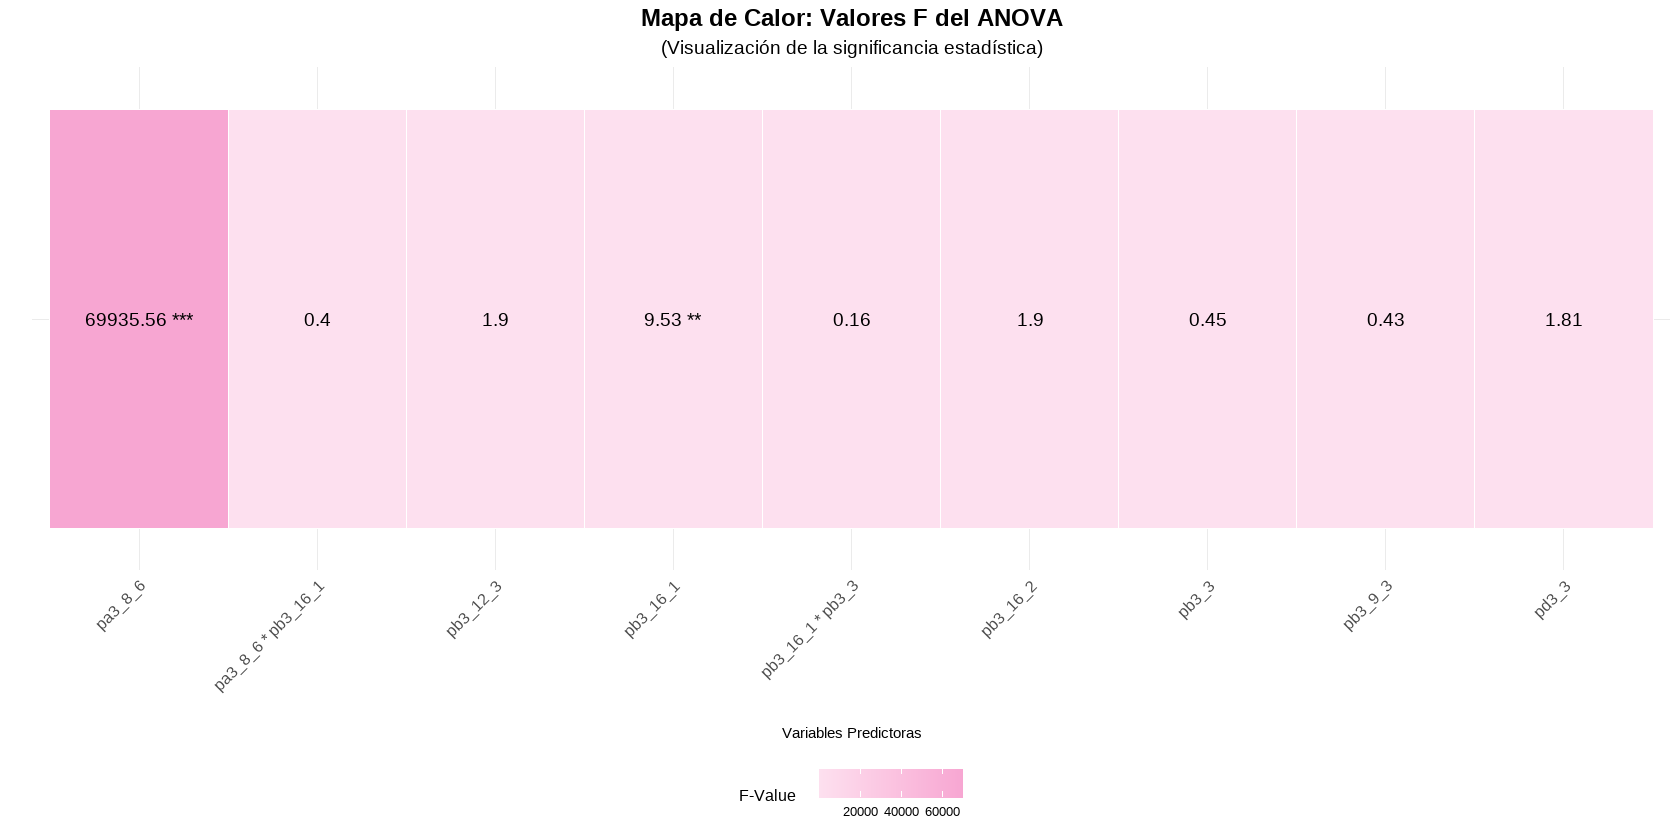

In [36]:
library(ggplot2)
library(dplyr)
library(tidyr)

# Crear el dataframe con los resultados del ANOVA
anova_results <- data.frame(
  Variable = c("pa3_8_6", "pb3_16_1", "pb3_3", "pb3_9_3", "pd3_3", "pb3_12_3", "pb3_16_2",
               "pa3_8_6 * pb3_16_1", "pb3_16_1 * pb3_3"),
  F_value = c(69935.558, 9.528, 0.454, 0.431, 1.808, 1.902, 1.902, 0.397, 0.157),
  Pr_F = c(2e-16, 0.00204, 0.50064, 0.56196, 0.89296, 0.79472, 0.67925, 0.67285, 0.69184)
)

# Transformar valores de p a una escala de significancia
anova_results <- anova_results %>%
  mutate(Significancia = case_when(
    Pr_F < 0.001 ~ "***",
    Pr_F < 0.01  ~ "**",
    Pr_F < 0.05  ~ "*",
    Pr_F < 0.1   ~ ".",
    TRUE         ~ " "
  ))

# Crear el mapa de calor con valores de F
ggplot(anova_results, aes(x = Variable, y = "F-Value", fill = F_value)) +
  geom_tile(color = "white", size = 0.5) +  # Borde blanco entre celdas
  scale_fill_gradientn(colors = c("#fde0ef", "#f7a6d2")) +  # Degradado en tonos rosas
  geom_text(aes(label = paste0(round(F_value, 2), " ", Significancia)), size = 5, color = "black") +  # Mostrar valores en celdas
  labs(
    title = "Mapa de Calor: Valores F del ANOVA",
    subtitle = "(Visualización de la significancia estadística)",
    x = "Variables Predictoras",
    y = "",
    fill = "F-Value"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
    plot.subtitle = element_text(size = 14, hjust = 0.5),
    axis.text.x = element_text(size = 12, angle = 45, hjust = 1),  # Mejor ajuste de etiquetas
    axis.text.y = element_blank(),  # Ocultar eje Y porque solo hay "F-Value"
    legend.position = "bottom",
    legend.title = element_text(size = 12),
    legend.text = element_text(size = 10)
  )


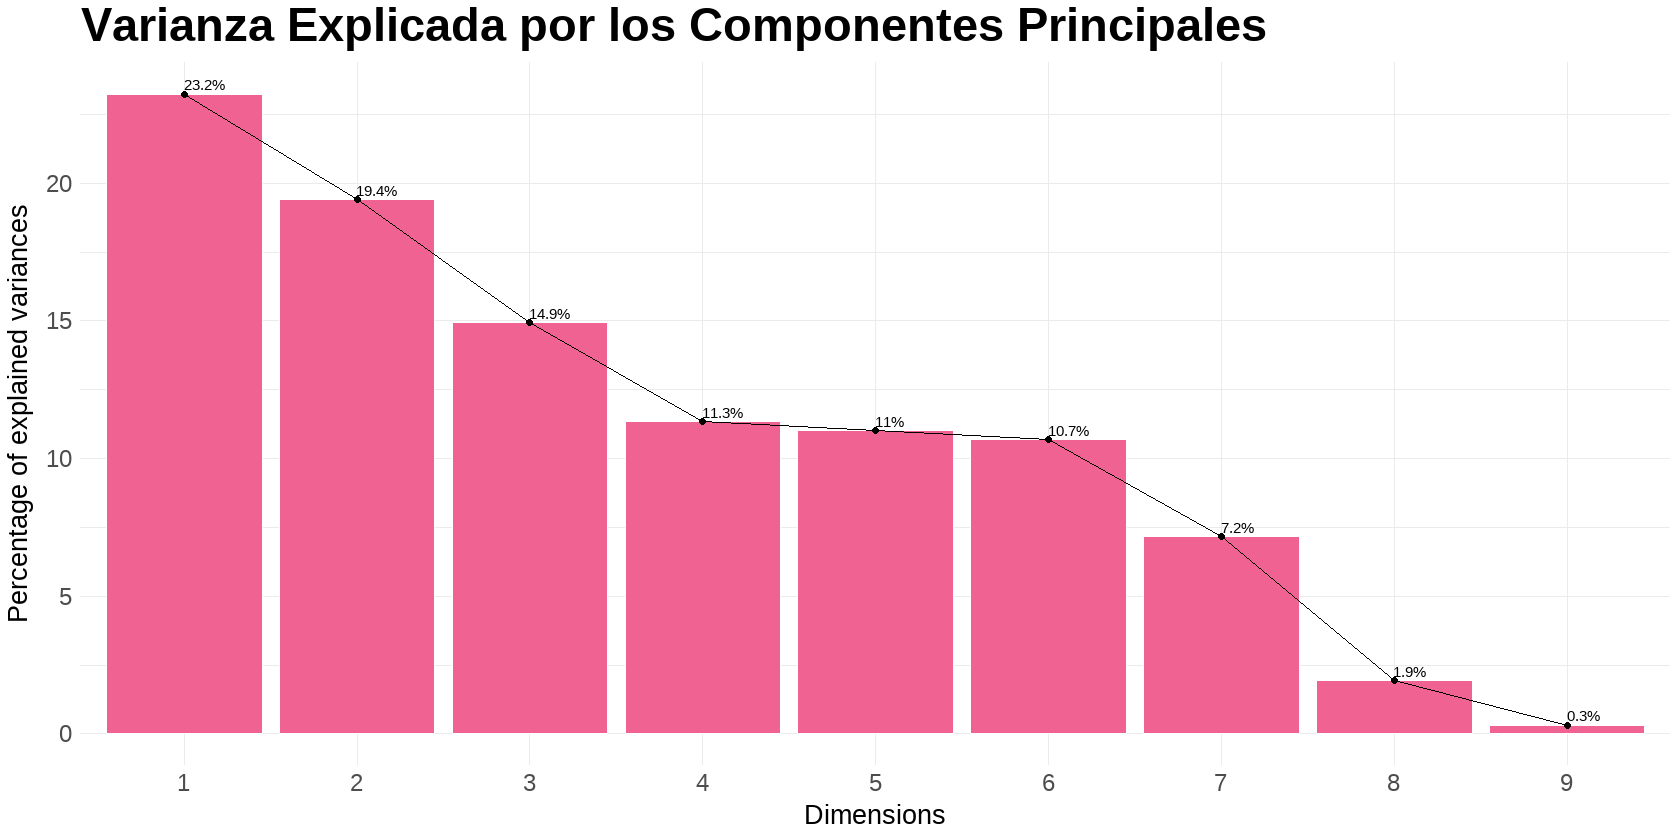

In [57]:
# Filtrar y limpiar datos (eliminar NA)
pca_data <- dm %>%
  filter(uni_actual == 1) %>%
  drop_na(pa3_6, pa3_8_6, pb3_9_3, pd3_3, pb3_12_3, 
          pb3_16_1, pb3_16_2, pd3_1, pb3_3) %>%
  select(pa3_6, pa3_8_6, pb3_9_3, pd3_3, pb3_12_3, 
         pb3_16_1, pb3_16_2, pd3_1, pb3_3)

# Convertir variables categóricas a factores numéricos
pca_data <- pca_data %>%
  mutate(across(everything(), as.numeric))

# Realizar Análisis de Componentes Principales (PCA)
pca_result <- PCA(pca_data, scale.unit = TRUE, ncp = 10, graph = FALSE)

# Visualizar la varianza explicada con aumento en el tamaño de letra
fviz_eig(pca_result, addlabels = TRUE, barfill = "#f06292", barcolor = "#ffffff") +
  labs(title = "Varianza Explicada por los Componentes Principales") +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 35, face = "bold"),  # Título más grande
    axis.title = element_text(size = 20),  # Tamaño de títulos de ejes
    axis.text = element_text(size = 18),  # Tamaño de etiquetas de ejes
    legend.text = element_text(size = 25)  # Tamaño de etiquetas de la leyenda
  )



In [56]:
pca_result

**Results for the Principal Component Analysis (PCA)**
The analysis was performed on 3420 individuals, described by 9 variables
*The results are available in the following objects:

   name               description                          
1  "$eig"             "eigenvalues"                        
2  "$var"             "results for the variables"          
3  "$var$coord"       "coord. for the variables"           
4  "$var$cor"         "correlations variables - dimensions"
5  "$var$cos2"        "cos2 for the variables"             
6  "$var$contrib"     "contributions of the variables"     
7  "$ind"             "results for the individuals"        
8  "$ind$coord"       "coord. for the individuals"         
9  "$ind$cos2"        "cos2 for the individuals"           
10 "$ind$contrib"     "contributions of the individuals"   
11 "$call"            "summary statistics"                 
12 "$call$centre"     "mean of the variables"              
13 "$call$ecart.type" "standard error 

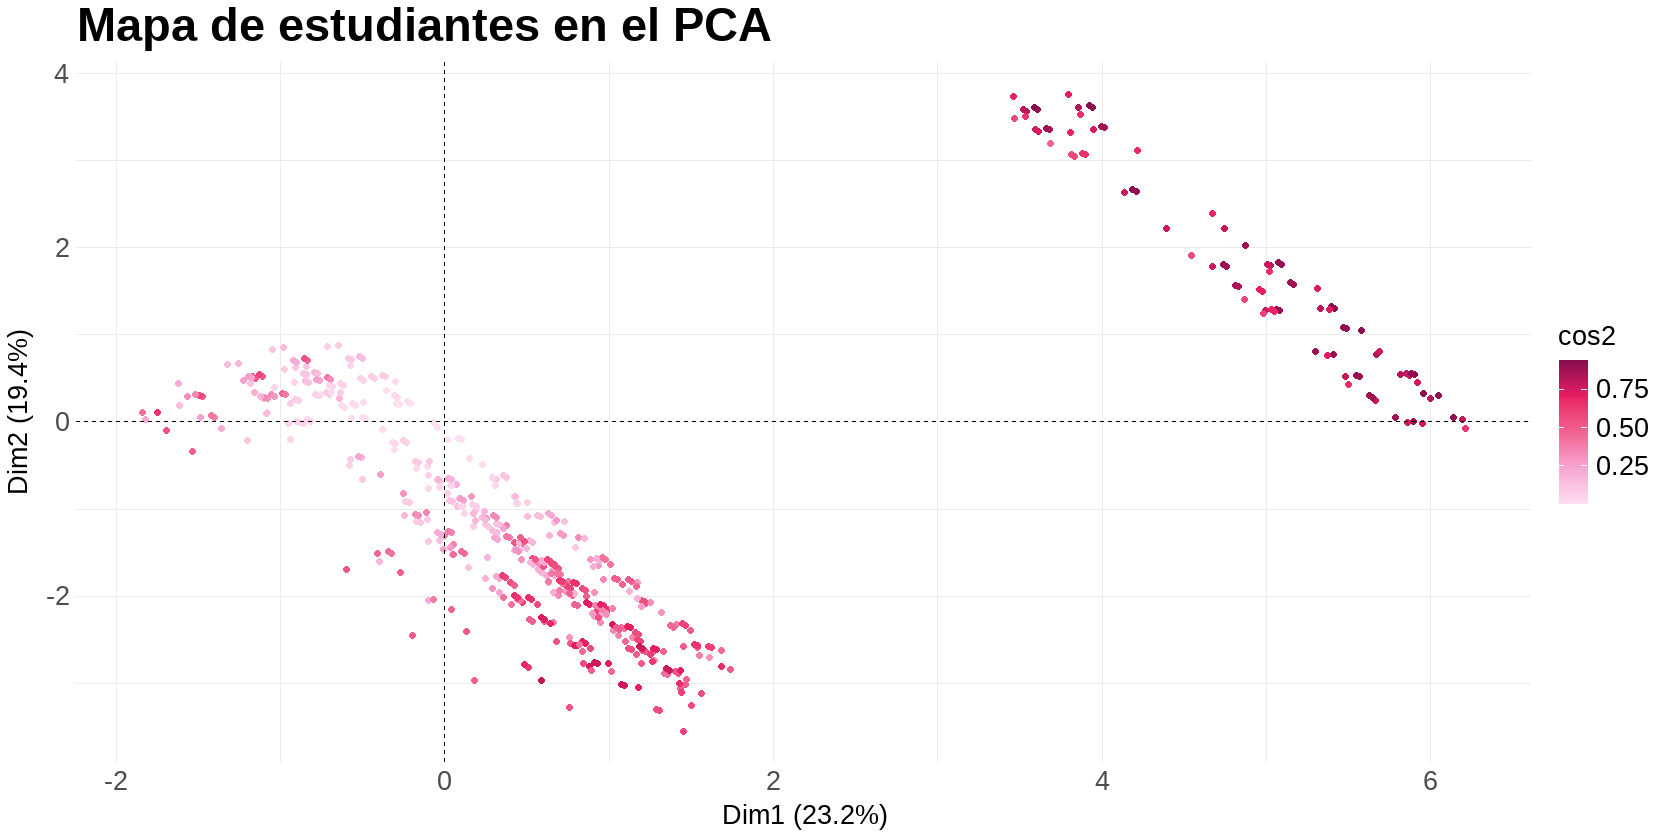

In [66]:
fviz_pca_ind(pca_result, geom = "point", col.ind = "cos2",
             gradient.cols = c("#fde0ef", "#f7a6d2", "#f06292", "#e91e63", "#880e4f"),
             repel = TRUE) +
  labs(title = "Mapa de estudiantes en el PCA") +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 35, face = "bold"),  # Título más grande
    axis.title = element_text(size = 20),  # Tamaño de títulos de ejes
    axis.text = element_text(size = 20),  # Tamaño de etiquetas de ejes
    legend.text = element_text(size = 20),  # Tamaño de etiquetas de la leyenda
    legend.title = element_text(size = 20)  # Tamaño del título de la leyenda
  )


#### 📊 Análisis de Factores que Influyen en el Rendimiento Académico  

##### **📌 1️⃣ ¿Cuáles son las correlaciones más significativas entre las variables y el rendimiento académico?**

##### **Variables más significativas (`Pr(>F) < 0.05`)**  
✅ **`pa3_8_6`** (Persona evaluada con asistencia) → **Muy significativa (`p < 2e-16, ***`)**  
✅ **`pb3_16_1`** (Se siente tensionado o estresado) → **Significativa (`p = 0.00204, **`)**  
✅ **`pd3_1`** (Condición de actividad) → **Marginalmente significativa (`p = 0.09306, .`)**  

##### **Variables con menor impacto (`p > 0.05, no significativas`)**  
🔹 `pb3_3` (Tipo de escuela pública/privada)  
🔹 `pb3_9_3` (Regularización en la escuela)  
🔹 `pd3_3` (Consecuencias si deja de trabajar)  
🔹 `pb3_12_3` (Uso de computadora)  
🔹 `pb3_16_2` (Se siente triste o deprimido)  

📌 **Conclusión:** **La asistencia (`pa3_8_6`) y el nivel de estrés (`pb3_16_1`) son los factores más influyentes en el rendimiento académico (`pa3_6`).**  

---

##### **📌 2️⃣ ¿Es posible reducir la dimensionalidad sin perder información importante?**
A partir del **PCA**, observamos que los **primeros 3-4 componentes principales capturan más del 60% de la varianza**:

📊 **Varianza Explicada**  
- **CP1** → **23.2%**  
- **CP2** → **19.4%**  
- **CP3** → **14.9%**  
- **CP4** → **11.3%**  

📌 **Conclusión:**  
✅ **Reducir a los primeros 3-4 componentes permite conservar más del 60% de la información sin perder detalles clave sobre el rendimiento académico.**  
✅ **Componentes posteriores (`CP6 en adelante`) aportan poca información y pueden descartarse.**  

---

##### **📌 3️⃣ ¿Qué factores principales explican la mayor variabilidad en los datos sobre el rendimiento académico?**

##### **Variables con mayor contribución en `CP1` (factor más importante)**  
🔹 `pa3_8_6` (Persona evaluada con asistencia)  
🔹 `pb3_16_1` (Se siente tensionado/estresado)  
🔹 `pb3_3` (Tipo de escuela)  
🔹 `pb3_9_3` (Regularización en la escuela)  

##### **Variables con mayor contribución en `CP2`**  
🔹 `pd3_1` (Condición de actividad)  
🔹 `pd3_3` (Consecuencias de dejar de trabajar)  
🔹 `pb3_16_2` (Se siente triste/deprimido)  

📌 **Conclusión:**  
✅ **El rendimiento académico está fuertemente influenciado por la asistencia a clases, el nivel de estrés y el tipo de escuela.**  
✅ **Factores emocionales y la condición laboral también explican parte de la variabilidad, pero en menor medida.**  